# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import datetime as dt
from operator import attrgetter
from dateutil.relativedelta import relativedelta

# Helpers

In [ ]:
def get_date_int(df, col):
  year = df[col].dt.year
  month = df[col].dt.month
  day = df[col].dt.day 
  return year, month, day

# Data 

In [ ]:
online = pd.read_csv(".Data/online12m.csv",index_col=0)

In [ ]:
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom
482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom
263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom
495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom
204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom


The dataset contains records of invoices for an E-Commerce company over the course of the year 2010.

In [ ]:
online.InvoiceDate = pd.to_datetime(online.InvoiceDate)

In [ ]:
online.InvoiceDate.agg({"max","min"})

min   2010-12-01 08:26:00
max   2011-12-09 12:49:00
Name: InvoiceDate, dtype: datetime64[ns]

Only want to include full months

In [ ]:
online = online[online.InvoiceDate <= online.InvoiceDate.min() + relativedelta(years=1)]
online.InvoiceDate.agg({"max","min"})

max   2011-11-30 17:37:00
min   2010-12-01 08:26:00
Name: InvoiceDate, dtype: datetime64[ns]

In [ ]:
online.to_csv(path + "online12m.csv")

Create Total Sum Column

In [ ]:
online["TotalSum"] = online.Quantity*online.UnitPrice

# Build Cohort Counts Table

Want group customers into cohorts according the month they made there first purchase

**Want to get InvoiceDay, Cohort Day Columns, Day Diff**

In [ ]:
# Create InvoiceDay column
online['InvoiceDay'] = online['InvoiceDate'].apply(lambda x:dt.datetime(x.year, x.month, x.day))

#Find the first ('min') day that a customer (identified by CustomerID) made a purchase, store as FirstPurchaseDay
grouping = online.groupby('CustomerID')['InvoiceDay'] 
online['FirstPurchaseDay'] = grouping.transform('min')

# Store the number of days between current and first invoice
online['DaysBetweenPurchase'] =(online.InvoiceDay - online.FirstPurchaseDay).dt.days
online.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,FirstPurchaseDay,DaysBetweenPurchase,InvoiceMonth,CohortMonth,Cohort_MonthDiff
416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom,2011-10-25,2011-04-11,197,2011-10,2011-04,6
482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom,2011-11-20,2011-09-12,69,2011-11,2011-09,2


**Want to get the previous three columns but for month**

In [ ]:
online['InvoiceMonth'] = online['InvoiceDate'].dt.to_period("M")
online['CohortMonth'] = online.groupby('CustomerID')['InvoiceMonth'].transform('min')
online['Cohort_MonthDiff'] =(online.InvoiceMonth - online.CohortMonth).apply(attrgetter('n')) #Difference is a DateOffset class with attribute n (which is the desired difference)

In [ ]:
online.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,FirstPurchaseDay,DaysBetweenPurchase,InvoiceMonth,CohortMonth,Cohort_MonthDiff
416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom,2011-10-25,2011-04-11,197,2011-10,2011-04,6
482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom,2011-11-20,2011-09-12,69,2011-11,2011-09,2


Groupby Cohort and MonthDiff (months since cohort month) and apply nunique to get the total number of customers in the cohort

In [ ]:
cohort_data = online.groupby(['CohortMonth', 'Cohort_MonthDiff'])['CustomerID'].apply(pd.Series.nunique).reset_index().rename({"CustomerID":"NumCustomersinCohort"},axis=1)

In [ ]:
cohort_data.head()

,CohortMonth,Cohort_MonthDiff,NumCustomersinCohort
0,2010-12,0,716
1,2010-12,1,246
2,2010-12,2,221
3,2010-12,3,251
4,2010-12,4,245


What this is doing is for each month, taking the average value of customerID for each column value. Since there is only one value for each column, this is simply a reorganization from long to wide format

In [ ]:
cohort_counts = cohort_data.pivot_table(index="CohortMonth",columns="Cohort_MonthDiff",values="NumCustomersinCohort",aggfunc='mean')

This table contains the number of customers who made their first purchase in a given month, and how many of those customers remain in the following months of the year. <br> <br> For example, in Dec 2010 716 new customers made a transaction. Of these customers, 172 were still making transactions 12 months later.  

In [ ]:
cohort_counts.to_csv("./Data/cohort_counts.csv")

# Cohort Analysis

## Churn and Rentention Rates

In [ ]:
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
churn = 1 - retention

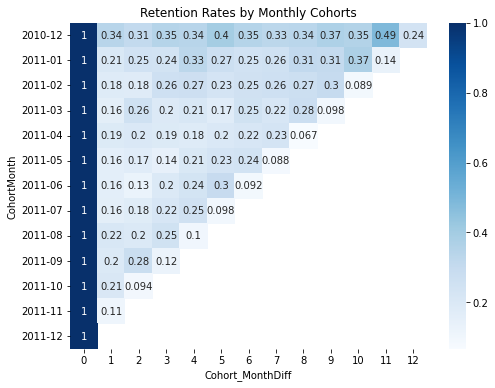

In [ ]:
plt.figure(figsize=(8, 6))
plt.title('Retention Rates by Monthly Cohorts')

sns.heatmap(retention, annot=True, cmap='Blues')
plt.show()

In [ ]:
# Calculate Total Mean Churn and Retention Rate
retention_rate = retention.iloc[:,1:].mean(axis=1).mean()
churn_rate = churn.iloc[:,1:].mean(axis=1).mean()
print('Retention rate: {:.2f}; Churn rate: {:.2f}'.format(retention_rate, churn_rate))

Retention rate: 0.20; Churn rate: 0.80


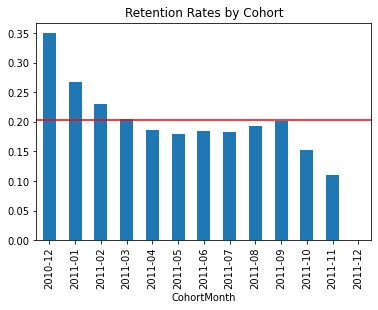

In [ ]:
# Calculate Mean Retention Rate for each Cohort
retention_rate_cohort = retention.iloc[:,1:].mean(axis=1)
retention_rate_cohort.plot(kind='bar')
plt.title("Retention Rates by Cohort")
plt.axhline(y=retention_rate, color='r', linestyle='-');

## Average Unit Price per cohort throughout the year

In [ ]:
cohort_data = online.groupby(["CohortMonth","Cohort_MonthDiff"])['UnitPrice'].agg("mean").reset_index()
average_unit_price = cohort_data.pivot_table(index="CohortMonth",columns="Cohort_MonthDiff",values="UnitPrice",aggfunc='mean').round(2)

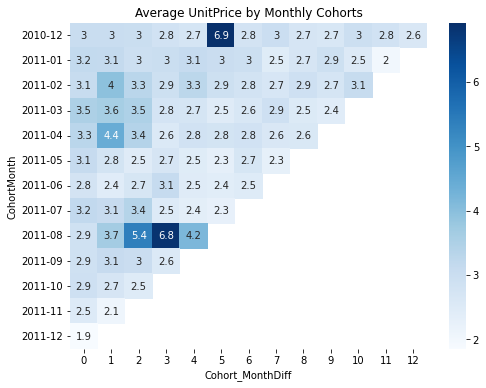

In [ ]:
plt.figure(figsize=(8, 6))
plt.title('Average UnitPrice by Monthly Cohorts')

sns.heatmap(average_unit_price, annot=True, cmap='Blues')
plt.show()

Customers who made their first purchse in August, seem to be purchasing expensive items. This is probably the result of a couple new customers who are doing so.

## Average Quantity

In [ ]:
cohort_data = online.groupby(["CohortMonth","Cohort_MonthDiff"])['Quantity'].agg("mean").reset_index()
average_quantity = cohort_data.pivot_table(index="CohortMonth",columns="Cohort_MonthDiff",values="Quantity",aggfunc='mean').round(2)

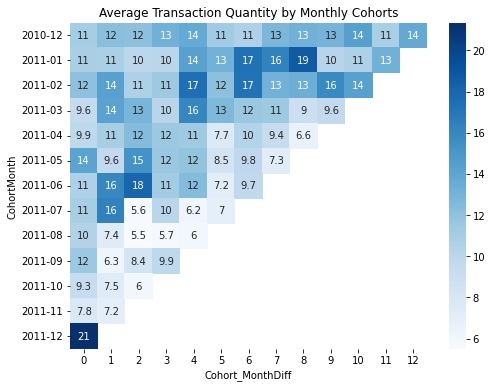

In [ ]:
plt.figure(figsize=(8, 6))
plt.title('Average Transaction Quantity by Monthly Cohorts')

sns.heatmap(average_quantity, annot=True, cmap='Blues')
plt.show()

# Projecting CLV

Note: 
* We dont have profit margin (and not estimating it) so only considering average revenue 

* Assume lifespan is 36 months

In [ ]:
lifespan_months = 36

## Basic CLV

Basic CLV = (**average revenue per customer per period**) * (**average customer lifespan**)  * (average profit margin in that period (not available)

Here, that means ->
Basic CLV = Average revenue per customer per month * 36

In [ ]:
# Calculate total monthly revenue per customer per month, then take average
monthly_revenue_ser = online.groupby(['CustomerID','InvoiceMonth'])['TotalSum'].sum()
avg_month_rev = monthly_revenue_ser.reset_index().groupby(['CustomerID'])['TotalSum'].mean()

In [ ]:
#Calculate basic clv
monthly_revenue = avg_month_rev.mean()
clv_basic = monthly_revenue * lifespan_months
print('Average basic CLV is {:.1f} USD'.format(clv_basic))

Average basic CLV is 3784.1 USD


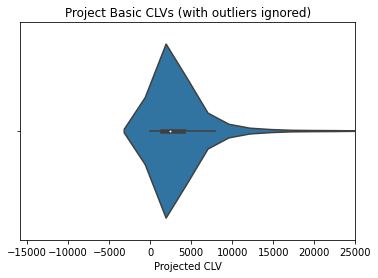

In [ ]:
#Plot Distibrutions of CLVs (with outliers removed)
sns.violinplot(x=avg_month_rev*36)
plt.title("Project Basic CLVs (with outliers ignored)")
plt.xlim(right=25000)
plt.xlabel("Projected CLV");

## Granular CLV

(**avg rev per purchase per period**) * (**average frequency**) * (profit margin) * **average lifespan**

In [ ]:
# Calculate average revenue per invoice
revenue_per_purchase = online.groupby(['InvoiceNo'])['TotalSum'].mean()

# Calculate average number of unique invoices per customer per month
frequency_per_month = online.groupby(['CustomerID','InvoiceMonth'])['InvoiceNo'].nunique().mean()

# Calculate granular CLV
clv_granular = revenue_per_purchase.mean() * frequency_per_month * lifespan_months

print('Average granular CLV is {:.1f} USD'.format(clv_granular))

Average granular CLV is 1635.2 USD


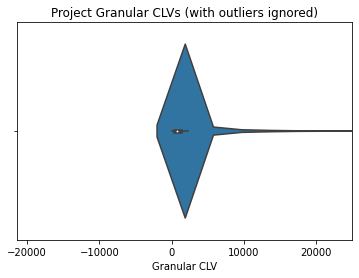

In [ ]:
#Plot Distibrutions of CLVs (with outliers removed)
gran_clvs = revenue_per_purchase * frequency_per_month * lifespan_months
sns.violinplot(x=gran_clvs)
plt.title("Project Granular CLVs (with outliers ignored)")
plt.xlim(right=25000)
plt.xlabel("Granular CLV");

## Traditional CLV

(**average revenue**) * (profit margin) * (**retention/(churn**))

In [ ]:
# Calculate monthly spend per customer
monthly_revenue = online.groupby(['CustomerID','InvoiceMonth'])['TotalSum'].sum()

# Calculate traditional CLV 
clv_traditional = monthly_revenue.mean() * (retention_rate / churn_rate)

# Print traditional CLV and the retention rate values
print('Average traditional CLV is {:.1f} USD at {:.1f} % retention_rate'.format(clv_traditional, retention_rate*100))

Average traditional CLV is 33.9 USD at 20.4 % retention_rate


Note: Traditional CLV is typically lower than both Basic and Granular, but not this much lower. This is likely due to the retention rates from the last month, either there is data corruption or the company performed extraordinarily poor 

In [ ]:
retention2 = retention.iloc[:-1,:-1]

In [ ]:
mask_arr = np.flipud(np.tri(*retention2.shape)).astype('bool')
mask_df = pd.DataFrame(mask_arr,index = retention2.index,columns=retention2.columns)
retention2 = retention2[mask_df]
retention_rate = retention2.iloc[:,1:].mean(axis=1).mean()
churn_rate = 1 - retention_rate

In [ ]:
temp = online[online.InvoiceMonth < online.InvoiceMonth.max()]

In [ ]:
# Calculate monthly spend per customer
monthly_revenue = temp.groupby(['CustomerID','InvoiceMonth'])['TotalSum'].sum()

# Calculate traditional CLV 
clv_traditional = monthly_revenue.mean() * (retention_rate_new / churn_rate_new)

# Print traditional CLV and the retention rate values
print('Average traditional CLV is {:.1f} USD at {:.1f} % retention_rate'.format(clv_traditional, retention_rate*100))

Average traditional CLV is 70.4 USD at 23.5 % retention_rate


Still Project CLV is relatively low